# Comparing FCC & CFPB Complaint Data

by Mark Silverberg ([@Skram](https://twitter.com/skram)) <mark.silverberg@socrata.com>

### Objective
Tinker with [Sage Math Cloud](https://cloud.sagemath.com)-powered Jupyter Python notebooks and [Socrata](https://www.socrata.com/)-powered federal open data from two different organizations: [Federal Communications Commission](https://www.fcc.gov/consumer-help-center-data) (FCC) and the [Consumer Financial Protection Bureau](http://www.consumerfinance.gov/data-research/consumer-complaints/) (CFPB)

### The puzzle pieces

- Complaint data from [FCC ("CGB - Consumer Complaints Data")](https://opendata.fcc.gov/d/3xyp-aqkj) and [CFPB ("Consumer Complaints")](https://data.consumerfinance.gov/d/s6ew-h6mp) (easy API access to the data, powered by Socrata)
- Jupyter Notebook w/ [`pandas`](http://pandas.pydata.org/) (for the layout of this page, powered by Sage Math Cloud)
- [Plotly](https://plot.ly/python/) (for charting)
- US Census data via [Sunlight Foundation's `census` python package](https://github.com/sunlightlabs/census) (for state population estimates)
- [TextBlob](http://textblob.readthedocs.io/en/dev/) (for sentiment analysis)

### Please improve upon this

Depending on how you are viewing this, you can download the python notebook and expand upon this work! Please feel free to raise feature requests and suggestions on Github at https://github.com/marks/open-complaints-data/
____

## Setup
### Dependencies and variables

In [42]:
# for top secret credentials
import json
with open('secrets.json') as data_file:    
    secrets = json.load(data_file)

# for data analysis
import pandas as pd
import urllib

# for plotly plotting
import plotly.plotly as py
py.sign_in(secrets["PLOTLY"]["USER"], secrets["PLOTLY"]["API_KEY"])

# for Census querying
from census import Census
from us import states
census = Census(secrets["CENSUS"]["API_KEY"]) # dummy API account

# for iPython displaying
from IPython.display import display, Image, HTML

# variables
variables = {
    "date_received":{
        "fcc":"ticket_created",
        "cfpb":"date_received"
    },
    "state":{
        "fcc":"state",
        "cfpb":"state"
    },
    "endpoint":{
        "fcc":"https://opendata.fcc.gov/resource/sr6c-syda.json",
        "cfpb":"https://data.consumerfinance.gov/resource/jhzv-w97w.json"
    }
}
provider_keys = variables['endpoint'].keys()

query_templates = { # always make sure there is a LIMIT statement with a {n} variable
    'count_by_state':{
        "template":"SELECT {0} as state, count(*) as complaints GROUP BY {0} LIMIT {1}",
        "variables":["state"]
    },
#     'count_by_month_and_state':{
#         "template":"SELECT {0} as state, date_trunc_ym({1}) as date_received, count(*) GROUP BY {0}, {1} ORDER BY date_received LIMIT {2}",
#         "variables":["state","date_received"]
#     }
}
query_template_keys = query_templates.keys()

a_big_number = 10000000 # for SODA query limits

### Helper functions

In [43]:
# function to marry a query template and provider's normalized variables into an API query string
def form_query_url(template,provider):
    base_url = variables['endpoint'][provider]
    query_template = query_templates[template]
    
    # form array of variables for the query template
    format_variables = []
    for variable in query_template['variables']:
        format_variables.append(variables[variable][provider])
    format_variables.append(a_big_number) 

    # put template and format_variables together
    query_str = query_template['template'].format(*format_variables)
    return "{0}?$query={1}".format(base_url, urllib.quote(query_str))

# function to create a plotly-powered US-state choropleth
def us_state_choropleth(df,col_to_color_by,units,title,zmin=None,zmax=None):
    plotly_data = [ dict(
        type='choropleth',
        autocolorscale = True,
        locations = df['state'],
        z = df[col_to_color_by],
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = units
        )
    ) ]

    if zmin != None:
        plotly_data[0]['zmin'] = zmin
    if zmax != None: 
        plotly_data[0]['zmax'] = zmax
        
    plotly_layout = dict(
            title = title,
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
            ),
        )
    fig = dict( data=plotly_data, layout=plotly_layout )
    return fig

# function used with df.apply to normalize count per 100,000 popualation
def normalize_for_pop(row):
    pop = state_population_lookup.get(row['state'], None)
    if pop != None:
        rate = (int(row['complaints']) / float(pop))*100000
    else:
#         print "** state={0} isnt in state_population_lookup and wont have a rate calculated for it".format(row['state'])
        rate = None
    return rate

# function powered by TextBlob to return a dictionary of sentiment attributes
def sentiment_to_dict(str):
    blob = TextBlob(str)
    blob_sentiment = blob.sentiment
    return {'polarity':blob_sentiment.subjectivity, 'subjectivity': blob_sentiment.polarity}


## Fetch the data (for each query template and provider)

In [44]:
# fetch the data 

data = dict()

## fetch data for all query templates and providers
for template in query_template_keys:
    data[template] = {}
    for provider in provider_keys:
        url = form_query_url(template,provider)
        print "Fetching {0} for {1} at {2}".format(template,provider,url)
        data[template][provider] = pd.read_json(url)

Fetching count_by_state for cfpb at https://data.consumerfinance.gov/resource/jhzv-w97w.json?$query=SELECT%20state%20as%20state%2C%20count%28%2A%29%20as%20complaints%20GROUP%20BY%20state%20LIMIT%2010000000
Fetching count_by_state for fcc at https://opendata.fcc.gov/resource/sr6c-syda.json?$query=SELECT%20state%20as%20state%2C%20count%28%2A%29%20as%20complaints%20GROUP%20BY%20state%20LIMIT%2010000000


## Print some summary stats and raw count choropleths

In [45]:
images_to_display = []

print "Some summary data and graphics:"

template = 'count_by_state'
for provider in provider_keys:
    d = data[template][provider]
    print " - {0} for {1} has {2} rows for a total of {3} complaints".format(template, provider, len(d), d['complaints'].sum())

    fig = us_state_choropleth(d,'complaints','Number of Complaints','{0} Complaints by State'.format(provider.upper()))
    image_name = 'pyimage_{0}-{1}.png'.format(template, provider)
    py.image.save_as(fig, 'images/'+image_name)
    images_to_display.append(image_name)

counts_by_state_html = "<h2 style='text-align: center;'>Total # of Complaints per Data Source</h2><table><tr>"
for image_path in images_to_display:
    counts_by_state_html += '<td><img src="images/{0}" alt="{0}" /></td>'.format(image_path)
counts_by_state_html += "</tr></table>"

display(HTML(counts_by_state_html))

Some summary data and graphics:
 - count_by_state for cfpb has 63 rows for a total of 573023 complaints
 - count_by_state for fcc has 57 rows for a total of 488576 complaints


,


## Let's try normalizing complaint counts per 100k population

### First, get state populations from the US Census

In [46]:
## consistent with Census Fact Finder 'TOTAL POPULATION / Universe: Total population / 2009-2013 American Community Survey 5-Year Estimates'
pop_est_table_id = 'B01003_001E'
state_populations = census.acs.state(('NAME',pop_est_table_id), Census.ALL, year=2013) # http://1.usa.gov/1RAhxWq

## create lookup dictionary of population
state_population_lookup = dict()
for row in state_populations:
    state = states.lookup(row['state']).abbr
    pop = row[pop_est_table_id]
    state_population_lookup[state] = pop
    
print "Got population data for {0} 'states'".format(len(state_population_lookup))

Got population data for 52 'states'


### Plot normalized counts

In [47]:
# Normalized complaint counts per 100k population

images_to_display = []

template = 'count_by_state'
for provider in provider_keys:
    d = data[template][provider]
    d['complaint_rate_per_100k_pop'] = d.apply(normalize_for_pop, axis=1)

    fig = us_state_choropleth(d,'complaint_rate_per_100k_pop','Complaints Per 100k Pop.','{0} Complaints by State (per 100k population)'.format(provider.upper()))
    # py.iplot( fig, filename='d3-cloropleth-map' )
    image_name = 'pyimage_{0}-{1}-per100k.png'.format(template, provider)
    py.image.save_as(fig, 'images/'+image_name)
    images_to_display.append(image_name)

counts_by_state_html = "<h2 style='text-align: center;'>Normalized # of Complaints per 100k population per Data Source</h2><table><tr>"
for image_path in images_to_display:
    counts_by_state_html += '<td><img src="images/{0}" alt="{0}" /></td>'.format(image_path)
counts_by_state_html += "</tr></table>"

display(HTML(counts_by_state_html))

,


### Check out the top states by normalized complaint count

In [48]:
data['count_by_state']['fcc'].sort_values('complaint_rate_per_100k_pop', ascending=False).head(5)

,complaints,state,complaint_rate_per_100k_pop
8,2314,DC,373.604835
22,17324,MD,296.933702
6,11872,CO,231.905392
10,39859,FL,208.782538
52,14029,WA,205.716511


In [49]:
data['count_by_state']['cfpb'].sort_values('complaint_rate_per_100k_pop', ascending=False).head(5)

,complaints,state,complaint_rate_per_100k_pop
11,3332,DC,537.965129
12,3006,DE,330.894737
26,18256,MD,312.908200
13,55374,FL,290.050534
39,23139,NJ,261.978446


## Beginnings of playing with sentiment analysis

In [55]:
from textblob import TextBlob # read http://planspace.org/20150607-textblob_sentiment/ for a good overview

# fetch all CFPB complaints and their associated state
url = variables['endpoint']['cfpb']+"?$query="+urllib.quote("SELECT state, complaint_what_happened WHERE state IS NOT NULL AND complaint_what_happened IS NOT NULL LIMIT {0}".format(a_big_number))
all_cfpb = pd.read_json(url)
print "Got {0} complaints to CFPB with a non-null state and complaint narrative ".format(len(all_cfpb))

Got 74810 complaints to CFPB with a non-null state and complaint narrative 


In [51]:
# collect sentiment (polarity and subjectivity) and merge into dataframe
sentiment_series = all_cfpb.complaint_what_happened.apply(lambda s: pd.Series(sentiment_to_dict(s)))
all_cfpb['polarity'] = sentiment_series['polarity']
all_cfpb['subjectivity'] = sentiment_series['subjectivity']

In [52]:
# get average by state
cfpb_state_avgs = all_cfpb.groupby(['state']).mean()

# hacks because of Mark's pandas newbness
from StringIO import StringIO
csv = cfpb_state_avgs.to_csv()
CSV_DATA=StringIO(csv)
cfpb_state_avgs = pd.read_csv(CSV_DATA)

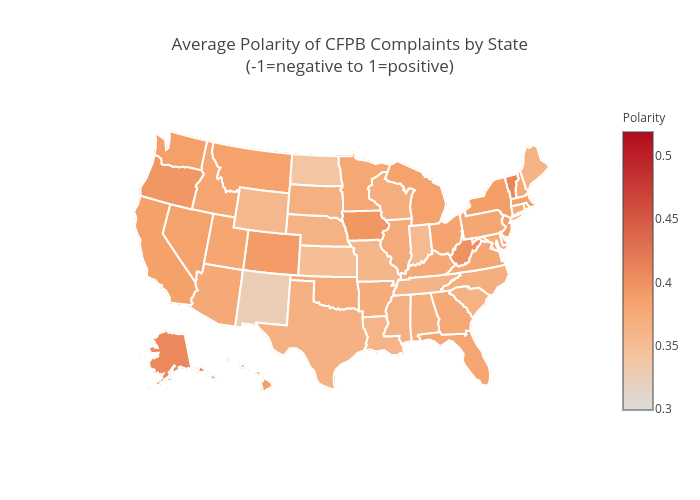

In [59]:
fig = us_state_choropleth(cfpb_state_avgs,'polarity','Polarity','Average Polarity of CFPB Complaints by State<br />(-1=negative to 1=positive)')
# py.iplot( fig, filename='d3-cloropleth-map' )
image_name = 'pyimage_count_by_state-cfpb-sentiment_polarity.png'
py.image.save_as(fig, 'images/'+image_name)
Image('images/'+image_name)

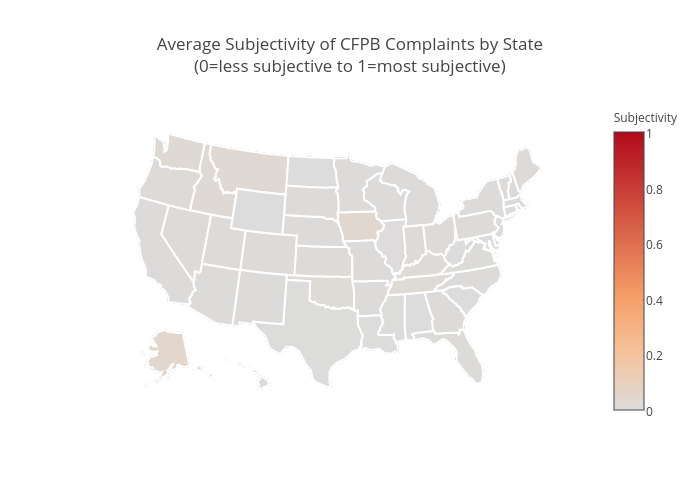

In [54]:
fig = us_state_choropleth(cfpb_state_avgs,'subjectivity','Subjectivity','Average Subjectivity of CFPB Complaints by State<br />(0=less subjective to 1=most subjective)',0,1)
# py.iplot( fig, filename='d3-cloropleth-map' )
image_name = 'pyimage_count_by_state-cfpb-sentiment_subjectivity.png'
py.image.save_as(fig, 'images/'+image_name)
Image('images/'+image_name)